# Imports classiques

Nous allons tout d'abord lancer les imports classiques


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Optim as opt
import functions as func

In [2]:
def contour_and_f_plot(res,function, levels=None,xmin=-2,xmax=2,ymin=-2,ymax=2):
    xiter=np.array(res['list_x'])
    fig, axarr = plt.subplots(2, 2, figsize=(16,8))
    # First plot 
    axarr[0,0].set_title('Points and levelset')
    Nx = 1000
    Ny = 1000
    x = np.linspace(xmin,xmax,Nx)
    y = np.linspace(ymin,ymax,Ny)
    X, Y = np.meshgrid(x, y)
    Z=function.value((X,Y))
    if levels:
        CS = axarr[0,0].contour(X, Y, Z, levels)
    else:
        CS = axarr[0,0].contour(X, Y, Z)
    axarr[0,0].plot(xiter[:,0], xiter[:,1],'+')
    axarr[0,0].clabel(CS, inline=1, fontsize=10)
    axarr[0,0].axis('equal')
    # Second plot
    axarr[0,1].set_title('Evolution of the cost')
    fiter=np.array(res['list_costs'])
    if min(fiter) > 0:
        axarr[0,1].semilogy(fiter)
    else:
        axarr[0,1].plot(fiter)
    #Third plot
    axarr[1,0].set_title('Norm of the gradient')
    giter=np.array(res['list_grads'])
    axarr[1,0].semilogy(giter)
    #Fourth plot
    axarr[1,1].set_title('Steps')
    siter=np.array(res['list_steps'])
    axarr[1,1].plot(siter)
    plt.show()


## L-BFGS

Nous allons nous intéresser à l'algorithme Limited Memory BFGS. Cet algorithme est du type BFGS, c'est à dire qu'il estime l'inverse de la Hessienne de $f$. Le L dans le nom de l'algorithme signifie qu'il est à mémoire limitée, c'est à dire qu'il ne garde en mémoire que les $L$ dernières itérations de calcul pour estimer la Hessienne.
L'algorithme est le suivant : Nous sommes à l'itération $k$, nous notons $x_k$ l'itéré et nous avons stocké les vecteurs suivants pour tout $k_{min}\le i\le k$.
$$ s*i=x*{i}-x*{i-1} \text{ et } y_i=\nabla f(x*{i}) -\nabla f(x\_{i-1})$$
Et on a aussi stocké $\rho_i=\frac{1}{(s_i,y_i)}$. Tous les $\rho_i$ doivent être positifs.
L'algorithme est le suivant

$r=-\nabla J(x_k)$<br>
Pour $i=k,k-1,\dots k_{min}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\alpha_i=\rho_i(s_i \cdot r)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$r=r-\alpha_i y_i$<br>
$r=\displaystyle \frac{(s_k\cdot y_k)}{(y_k\cdot y_k)}r$<br>
Pour $i=k_{min},k_{min}+1,\dots,k$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\beta_i=\rho_i(y_i\cdot r)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$r=r+(\alpha_i-\beta_i)s_i$<br>
rend r

# Fonctions sur les listes

Vous aurez sans doute besoin des fonctions suivantes pour les listes


In [3]:
a=[(2*i,3*i) for i in range(5) ]
print(a)
print(a[3],a[-1])
print('*** Pop ***')
a.pop(0)
print(a)
print('*** Parcours ***')


import numpy as np

for e,f in a :
      print(e,'et',f)
print('*** Parcours Inverse***')
for e in reversed(a) :
      print(e)
b=[e**2 for e,f in a]
print(b)
print('*** Parcours de deux listes ensembles***')
for (m,(t,p)) in zip(b,a) :
    print(m,'et',t,'et encore',p)
print('*** Append ***')
print(b)
b.append(546)
print(b)
print('*** Inversion ***')
c=list(reversed(b))
print(c)
print(len(b))

[(0, 0), (2, 3), (4, 6), (6, 9), (8, 12)]
(6, 9) (8, 12)
*** Pop ***
[(2, 3), (4, 6), (6, 9), (8, 12)]
*** Parcours ***
2 et 3
4 et 6
6 et 9
8 et 12
*** Parcours Inverse***
(8, 12)
(6, 9)
(4, 6)
(2, 3)
[4, 16, 36, 64]
*** Parcours de deux listes ensembles***
4 et 2 et encore 3
16 et 4 et encore 6
36 et 6 et encore 9
64 et 8 et encore 12
*** Append ***
[4, 16, 36, 64]
[4, 16, 36, 64, 546]
*** Inversion ***
[546, 64, 36, 16, 4]
5


# Class BFGS

Créez une classe `BFGS` dans `LibOptim.py`, sa fonction `__init__` sera de la forme
`__init__(self,nb_stock_max=8)` où `nb_stock_max` est le nombre maximum d'itérations prises en compte. Cette fonction créera aussi une liste vide appelée `stock` qui conserve les $s_i,g_i,\rho_i$. Elle devra aussi créer une liste vide nommée `last_iter`.

# Push

Nous allons maintenant créer une fonction `push(self, x, grad)` qui enregistre $s_k,g_k,\rho_k$. Pour cela, on a besoin de $x_{k-1},\nabla f(x_{k-1})$. Si ils existent, ils se trouvent dans la liste `self.last_iter`. Ensuite on peut calculer $s_k,g_k$ et $\rho_k$.

Si $\rho_k$ est positif, alors on enregistre le triplet $(s_k,g_k,\rho_k)$ à la fin de la liste `self.stock`, en vérifiant `self.stock` ne doit contenir au maximum que les dernières `self.nb_stock_max` itérations (si nécessaire on retire le tout premier élément de `self.stock`).

Si $\rho_k$ est négatif, quelquechose c'est mal passé, on vide le `self.stock`.

A la fin, on n'oublie pas de mettre $x_{k}$ et $\nabla f(x_{k})$ dans `self.last_iter` pour être sûr de les y trouver la prochaine fois.

# Get

Nous allons maintenant créer une fonction `get(self, grad)` qui modifie la direction de descente et applique l'algorithme ci-dessus. Cette fonction doit nous rendre le `r` final. Si le `self.stock` est vide, cette fonction doit nous rendre `-grad`

# dc

Nous créeons maintenant une fonction `dc(self,x,function,df)` qui appplique tout d'abord `self.push` puis `self.get`, elle rend le résultat de la fonction de `self.get` et une variable d'info.

# C'est l'heure de tester ...

Lancez une méthode de Newton_Wolfe sur votre fonction préférée et à chaque itération calculez ce que donnerait un L-BFGS. Comparez les angles des directions entre la méthode de Newton et le L-BFGS, comparez aussi le ration des normes. Ensuite lancez un LBFGS avec recherche de pas de Wolfe sur vos tests préférez et obtenez le comportement de Newton_Wolfe sans le calcul de la Hessienne...


Fonction (x,y) --> 100*(y-x^2)^2 + (1-x)^2
iter=   0 f=4.040e+02 df=8.980e+02 comp=[   1,   1,   0]
iter=   1 f=2.978e+01 df=1.644e+02 comp=[  21,   3,   1]
iter=   2 f=1.820e+01 df=2.100e+02 comp=[  35,   5,   2]
iter=   3 f=1.690e+01 df=2.930e+02 comp=[  49,   7,   3]
iter=   4 f=1.202e+00 df=6.045e+01 comp=[  73,   9,   4]
iter=   5 f=3.920e-01 df=6.106e+00 comp=[  97,  11,   5]
iter=   6 f=3.840e-01 df=8.433e-01 comp=[ 121,  13,   6]
iter=   7 f=3.839e-01 df=1.014e+00 comp=[ 143,  15,   7]
iter=   8 f=3.839e-01 df=1.233e+00 comp=[ 165,  17,   8]
iter=   9 f=3.835e-01 df=3.925e-01 comp=[ 189,  19,   9]
iter=  10 f=3.833e-01 df=1.200e+00 comp=[ 207,  21,  10]
iter=  11 f=3.829e-01 df=3.906e-01 comp=[ 231,  23,  11]
iter=  12 f=3.827e-01 df=1.163e+00 comp=[ 249,  25,  12]
iter=  13 f=3.824e-01 df=3.885e-01 comp=[ 273,  27,  13]
iter=  14 f=3.821e-01 df=1.122e+00 comp=[ 291,  29,  14]
iter=  15 f=3.818e-01 df=3.864e-01 comp=[ 315,  31,  15]
iter=  16 f=3.817e-01 df=2.182e+00 comp=[ 331

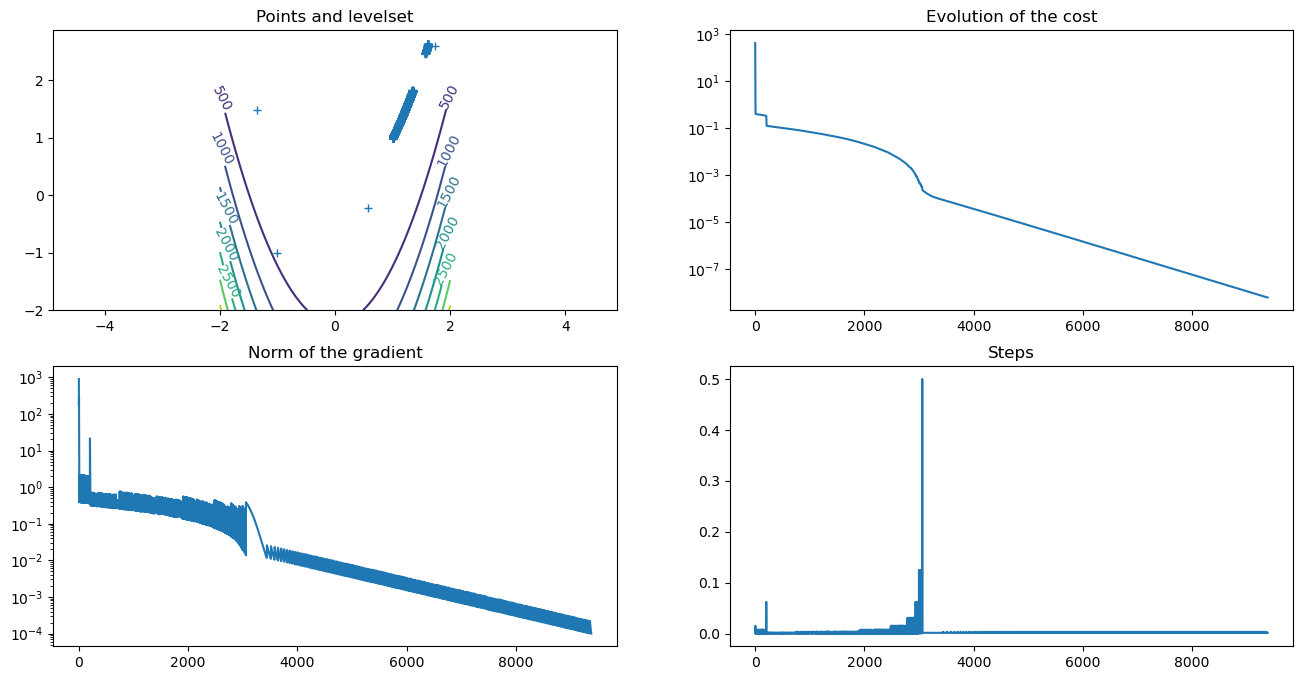

In [9]:
f=func.Rosen()
x0=np.array([-1,-1])
res=opt.main_algorithm(f,1.,x0,ls=opt.ls_wolfe_step_is_one,dc=opt.dc_newton,verbose=True)
contour_and_f_plot(res,f)

In [10]:
# Execute Newton-Wolfe method
result_newton = opt.main_algorithm(func.Rosen(), 1.0, np.array([0.0, 0.0]), dc=opt.dc_newton, ls=opt.ls_wolfe)

# Execute L-BFGS-B with Wolfe line search
result_lbfgs_wolfe = opt.main_algorithm(func.Rosen(), 1.0, np.array([0.0, 0.0]), dc=opt.BFGS.dc, ls=opt.ls_wolfe)

# Compare directions' angles and norm ratios
for i in range(1, len(result_newton['list_x'])):
    angle_newton = np.arccos(np.dot(result_newton['list_x'][i] - result_newton['list_x'][i - 1],
                                   result_newton['list_x'][i - 1]) /
                             (np.linalg.norm(result_newton['list_x'][i] - result_newton['list_x'][i - 1]) *
                              np.linalg.norm(result_newton['list_x'][i - 1])))
    
    angle_lbfgs = np.arccos(np.dot(result_lbfgs_wolfe['list_x'][i] - result_lbfgs_wolfe['list_x'][i - 1],
                                  result_lbfgs_wolfe['list_x'][i - 1]) /
                            (np.linalg.norm(result_lbfgs_wolfe['list_x'][i] - result_lbfgs_wolfe['list_x'][i - 1]) *
                             np.linalg.norm(result_lbfgs_wolfe['list_x'][i - 1])))

    ratio_norms = np.linalg.norm(result_newton['list_x'][i] - result_newton['list_x'][i - 1]) / \
                   np.linalg.norm(result_lbfgs_wolfe['list_x'][i] - result_lbfgs_wolfe['list_x'][i - 1])

    print(f"Iteration {i}:")
    print(f"Angle Newton-Wolfe: {np.degrees(angle_newton)} degrees")
    print(f"Angle L-BFGS-Wolfe: {np.degrees(angle_lbfgs)} degrees")
    print(f"Ratio of norms: {ratio_norms}")
    print("\n")


Fonction (x,y) --> 100*(y-x^2)^2 + (1-x)^2
iter=   0 f=1.000e+00 df=2.000e+00 comp=[   1,   1,   0]
iter=   1 f=9.531e-01 df=1.337e+01 comp=[   9,   3,   1]
iter=   2 f=8.934e-01 df=1.208e+01 comp=[  19,   5,   2]
iter=   3 f=8.151e-01 df=1.105e+01 comp=[  21,   7,   3]
iter=   4 f=7.872e-01 df=1.042e+01 comp=[  23,   9,   4]
iter=   5 f=7.461e-01 df=1.002e+01 comp=[  25,  11,   5]
iter=   6 f=7.386e-01 df=9.887e+00 comp=[  27,  13,   6]
iter=   7 f=7.192e-01 df=9.991e+00 comp=[  29,  15,   7]
iter=   8 f=5.292e-01 df=1.320e+00 comp=[  33,  17,   8]
iter=   9 f=5.167e-01 df=1.302e+00 comp=[  37,  20,   9]
iter=  10 f=5.046e-01 df=1.287e+00 comp=[  39,  22,  10]
iter=  11 f=4.931e-01 df=1.280e+00 comp=[  41,  24,  11]
iter=  12 f=4.819e-01 df=1.281e+00 comp=[  43,  26,  12]
iter=  13 f=4.713e-01 df=1.298e+00 comp=[  45,  28,  13]
iter=  14 f=4.611e-01 df=1.337e+00 comp=[  47,  30,  14]
iter=  15 f=4.516e-01 df=1.416e+00 comp=[  49,  32,  15]
iter=  16 f=4.426e-01 df=1.553e+00 comp=[  51

TypeError: BFGS.dc() missing 1 required positional argument: 'df'

In [11]:
f=func.Rosen()
B=opt.BFGS(nb_stock_max=12)
x0=np.array([-1,-1])
res=opt.main_algorithm(f,0.1,x0,ls=opt.ls_wolfe,dc=B.dc,verbose=True)
contour_and_f_plot(res,f)

Fonction (x,y) --> 100*(y-x^2)^2 + (1-x)^2
iter=   0 f=4.040e+02 df=8.980e+02 comp=[   1,   1,   0]
iter=   1 f=1.997e+01 df=9.836e+01 comp=[  15,   3,   0]
iter=   2 f=1.449e+01 df=8.179e+01 comp=[  33,  13,   0]
iter=   3 f=1.402e+01 df=8.164e+01 comp=[  37,  16,   0]
iter=   4 f=1.402e+01 df=8.164e+01 comp=[ 119,  18,   0]
iter=   5 f=1.034e+01 df=6.950e+01 comp=[ 225,  72,   0]
iter=   6 f=8.346e+00 df=6.195e+01 comp=[ 321, 121,   0]
iter=   7 f=6.032e+00 df=5.184e+01 comp=[ 325, 124,   0]
iter=   8 f=3.571e+00 df=3.829e+01 comp=[ 327, 126,   0]
iter=   9 f=1.416e+00 df=2.017e+01 comp=[ 329, 128,   0]
iter=  10 f=5.808e-01 df=4.377e+00 comp=[ 331, 130,   0]
iter=  11 f=5.808e-01 df=4.377e+00 comp=[ 439, 132,   0]


KeyboardInterrupt: 